In [5]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import time
from functools import reduce
import pandas as pd
#import cupy as cp
# Disable if running on GPU
# from numba import jit, config
# config.DISABLE_JIT = True
# import cProfile
# import pandas as pd

sys.path.append("../gaia_tools/")
import data_analysis
import transformation_constants
import transformation_functions
import covariance_generation

from scipy.stats import norm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

In [6]:
# For local
#path = '/home/svenpoder/DATA/Gaia_DR3/GaiaDR3_RV_RGB_fidelity.csv'

In [9]:
print('Importing DR3...')
dr3_path = '/local/mariacst/2022_v0_project/data/GaiaDR3_RV_RGB_fidelity.csv'
gaia_dr3 = pd.read_csv(dr3_path)

r_est_error = (gaia_dr3.B_rpgeo - gaia_dr3.b_rpgeo)/2
gaia_dr3['r_est_error'] = r_est_error

columns_to_drop = ['Vbroad', 'GRVSmag', 'Gal', 'Teff', 'logg',
    '[Fe/H]', 'Dist', 'A0', 'RAJ2000', 'DEJ2000', 'e_RAJ2000', 'e_DEJ2000',
    'RADEcorJ2000', 'B_Teff', 'b_Teff', 'b_logg', 'B_logg', 'b_Dist',
    'B_Dist', 'b_AG', 'B_AG', 'b_A0', 'B_A0', 'Gmag', 'BPmag', 'RPmag', 'BP-RP']
gaia_dr3 = gaia_dr3.drop(columns=columns_to_drop)
print(gaia_dr3.columns)
icrs_data = gaia_dr3

Importing DR3...
Index(['Unnamed: 0', 'source_id', 'ra', 'dec', 'rgeo', 'b_rgeo', 'B_rgeo',
       'r_est', 'b_rpgeo', 'B_rpgeo', 'ra_error', 'dec_error', 'parallax',
       'parallax_error', 'PM', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error',
       'radial_velocity', 'radial_velocity_error', 'ra_dec_corr',
       'ra_pmdec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'dec_pmra_corr',
       'dec_pmdec_corr', 'dec_parallax_corr', 'parallax_pmdec_corr',
       'parallax_pmra_corr', 'pmra_pmdec_corr', 'r_est_error'],
      dtype='object')


In [5]:
## TRANSFORMATION CONSTANTS
v_sun = transformation_constants.V_SUN

r_0 = 8277.0
z_0 = 25.0

v_sun[0][0] = 11.1
v_sun[1][0] = 251.5*(r_0/8277)
v_sun[2][0] = 8.59*(r_0/8277)


## APPLY INITIAL CUT
galcen_data = data_analysis.get_transformed_data(data_icrs,
                                       include_cylindrical = True,
                                       z_0 = z_0,
                                       r_0 = r_0,
                                       v_sun = v_sun,
                                       debug = True,
                                       is_bayes = True,
                                       is_source_included = True)

galcen_data = galcen_data[(galcen_data.r < 15000) & (galcen_data.r > 5000)]
galcen_data = galcen_data[(galcen_data.z < 200) & (galcen_data.z > -200)]

# Remove halo stars (condition taken from 1806.06038)                        
v_dif = np.linalg.norm(np.array([galcen_data.v_x, galcen_data.v_y, galcen_data.v_z])-v_sun,
                    axis=0)                                               
galcen_data['v_dif'] = v_dif                                                 
galcen_data = galcen_data[galcen_data.v_dif<210.]

galcen_data.reset_index(inplace=True, drop=True)


## DECLARE FINAL INPUT DATA
data_icrs = data_icrs.merge(galcen_data, on='source_id')[data_icrs.columns]
print("Final size of sample {}".format(galcen_data.shape))


# Declare backend
NUMPY_LIB = cp
dtype = cp.float32

# Generate covariance matrices for INPUT
C_icrs = covariance_generation.generate_covmat(data_icrs)

# Export INPUT to GPU with needed columns
trans_needed_columns = ['source_id', 'ra', 'dec', 'r_est', 'pmra', 'pmdec', 'radial_velocity',]
icrs_data = NUMPY_LIB.asarray(data_icrs[trans_needed_columns], dtype=cp.float32)
C_icrs = NUMPY_LIB.asarray(C_icrs, dtype=cp.float32)

Starting galactocentric transformation loop over all data points.. 
Time elapsed for data coordinate transformation: 2.458794418722391 sec
Final size of sample (1694972, 11)


In [6]:
galcen_data = transformation_functions.get_transformed_data(icrs_data,
                                    include_cylindrical = True,
                                    z_0 = z_0,
                                    r_0 = r_0,
                                    v_sun = v_sun,
                                    is_bayes = True,
                                    NUMPY_LIB = NUMPY_LIB,
                                    dtype = dtype)

# ["ra", "dec","r_est","pmra","pmdec","radial_velocity"] -> [:,1::]
galactocentric_cov = covariance_generation.transform_cov_matrix(C = C_icrs, 
                                    df = icrs_data[:,1::],
                                    coordinate_system = 'Cartesian',
                                    z_0 = z_0,
                                    r_0 = r_0,
                                    is_bayes = True,
                                    NUMPY_LIB = NUMPY_LIB,
                                    dtype = dtype)

# ["x", "y","r","phi","v_r","v_phi"] -> [0,1,6,7,8,9]
cyl_cov_gpu = covariance_generation.transform_cov_matrix(C = galactocentric_cov, 
                                    df = galcen_data[:,[0,1,6,7,8,9]],
                                    coordinate_system = 'Cylindrical',
                                    z_0 = z_0,
                                    r_0 = r_0,
                                    is_bayes = False,
                                    NUMPY_LIB = NUMPY_LIB,
                                    dtype = dtype)

sig_vphi = NUMPY_LIB.array([cyl_cov_gpu[:,4,4]])
sig_vr = NUMPY_LIB.array([cyl_cov_gpu[:,3,3]])
source_id = NUMPY_LIB.array([icrs_data[:,0]])
galcen_data = NUMPY_LIB.concatenate(([galcen_data, sig_vphi.T, sig_vr.T, source_id.T]), axis=1)

final_data_columns = ['x', 'y', 'z', 'v_x', 'v_y', 'v_z', 'r', 'phi', 'v_r', 'v_phi',
            'sig_vphi', 'sig_vr', 'source_id']

galcen_data = pd.DataFrame(galcen_data.get(), columns=final_data_columns)



In [10]:
# CPU version

def load_galactic_parameters():
   
   # Initial Galactocentric distance
   r_0 = 8277

   # Initial height over Galactic plane
   z_0 = 25

   # Initial solar vector
   v_sun = transformation_constants.V_SUN
   v_sun[0][0] = 11.1
   v_sun[1][0] = 251.5
   v_sun[2][0] = 8.59
   
   return r_0, z_0, v_sun

r_0, z_0, v_sun = load_galactic_parameters()

galcen_data = data_analysis.get_transformed_data(icrs_data,
                                        include_cylindrical = True,
                                        z_0 = z_0,
                                        r_0 = r_0,
                                        v_sun = v_sun,
                                        debug = True,
                                        is_bayes = True,
                                        is_source_included = True)

C_icrs = covariance_generation.generate_covmat(icrs_data)


data_array_ICRS =  icrs_data[["ra", "dec","r_est","pmra","pmdec","radial_velocity"]].to_numpy()
galactocentric_cov = covariance_generation.transform_cov_matrix(C = C_icrs, 
                                    df = data_array_ICRS,
                                    coordinate_system = 'Cartesian',
                                    z_0 = z_0,
                                    r_0 = r_0,
                                    is_bayes = True)

cyl_cov = covariance_generation.transform_cov_cylindirical(
                                galcen_data, 
                                galactocentric_cov,
                                Z_0 = transformation_constants.Z_0,
                                R_0 = transformation_constants.R_0)


galcen_data = galcen_data.merge(cyl_cov, on='source_id')

# Final data cut
galcen_data = galcen_data[(galcen_data.r < 15000) & (galcen_data.r > 5000)]
galcen_data = galcen_data[(galcen_data.z < 200) & (galcen_data.z > -200)]

# Remove halo stars (condition taken from 1806.06038)                        
v_dif = np.linalg.norm(np.array([galcen_data.v_x, galcen_data.v_y, galcen_data.v_z])-v_sun,
                    axis=0)                                               
galcen_data['v_dif'] = v_dif                                                 
galcen_data = galcen_data[galcen_data.v_dif<210.]

galcen_data.reset_index(inplace=True, drop=True)

Starting galactocentric transformation loop over all data points.. 
Time elapsed for data coordinate transformation: 8.308439336717129 sec


In [11]:
galcen_data.shape

(1679257, 14)

In [12]:
r_min = 5000/8277
r_max = 15000/8277

# # Generate bins
bin_collection = data_analysis.get_collapsed_bins(data = galcen_data,
                                                    theta = r_0,
                                                    BL_r_min = r_min,
                                                    BL_r_max = r_max,
                                                    BL_z_min = -200,
                                                    BL_z_max = 200,
                                                    N_bins = (10, 1),
                                                    r_drift = True,
                                                    debug = False)

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


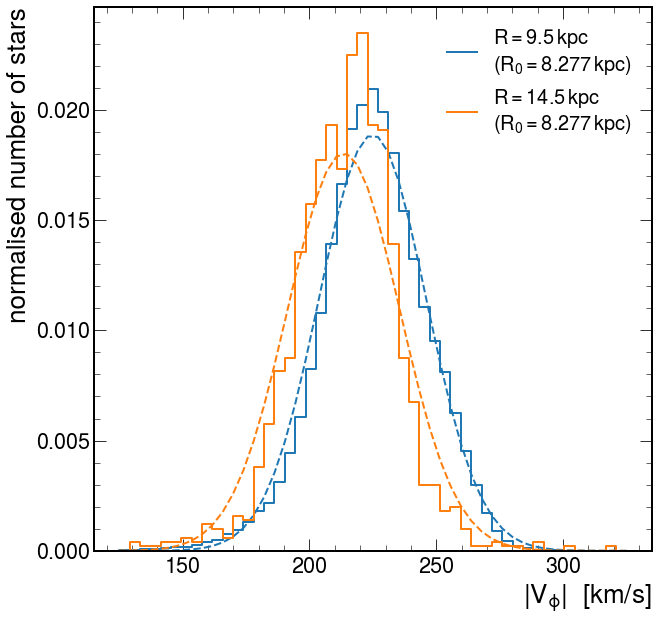

In [14]:
import mplhep
plt.style.use(mplhep.style.CMS)
import boost_histogram

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

bins = bin_collection.bins
i_list = [np.random.randint(10, size=1)[0], 9]

i_height = [0.9, 0.83, 0.76]
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

for i_color, i in enumerate(i_list):

    z_range = bins[i].z_boundaries
    r_range = bins[i].r_boundaries

    min_edge = 125
    max_edge = 325
    h0 = boost_histogram.Histogram(boost_histogram.axis.Variable(np.linspace(min_edge, max_edge, 50)))
    h0.fill(np.abs(bins[i].data.v_phi))


    r_loc = np.round(np.mean(bins[i].r_boundaries)*8277, 1)/1e3              
    mplhep.histplot(h0, 
                    histtype="step", 
                    ax=ax, 
                    yerr=False, 
                    lw=2, 
                    density=1, 
                    label=r"$R = {}\, kpc$".format(r_loc)+"\n"+r"($R_0 = 8.277 \, kpc$)")
   
    # add a 'best fit' line
    (mu, sigma) = norm.fit(np.abs(bins[i].data.v_phi))
    bin_edges = h0.axes.edges[0]
    y = norm.pdf(bin_edges, mu, sigma)
    plt.plot(bin_edges, y, '--', linewidth=2, color=colors[i_color])

plt.legend(loc=1, prop={'size': 20})

#plt.title(r"$V_\phi}$ Distribution")
plt.xlabel("$|{V_\phi}|}$  [km/s]")
plt.ylabel("normalised number of stars")
plt.savefig("vphi_dist.pdf", bbox_inches="tight")

In [ ]:
bin_collection.GetMLEParameters()

In [ ]:
test_bin = bin_collection.bins[1]
print(test_bin.z_boundaries)
print(test_bin.data.columns)

In [ ]:
def plot_velocity_distribution(bins, is_range=False, plot_MU=False):

    if(len(bins) % np.sqrt(len(bins)) == 0):
        figs_x = round(np.sqrt(len(bins)))
        figs_y = figs_x
    else:
        figs_x = round(np.sqrt(len(bins)))
        figs_y = figs_x+1

    if(len(bins) > 5):
        figsize = 15
    else:
        figsize = 10

    fig, axs = plt.subplots(figs_y, figs_x, figsize = (figsize,figsize))

    for i, ax in enumerate(axs.flat):
        if(i < len(bins)):

            if(np.abs(np.min(bins[i].data.v_phi) - np.max(bins[i].data.v_phi)) > 500):
                n_bins = 80
            else:
                n_bins = 40

            z_range = bins[i].z_boundaries
            r_range = bins[i].r_boundaries

            text_string = "$z \in [{:.1f}, {:.1f}]$\n$r \in [{:.1f}, {:.1f}]$".format(z_range[0], z_range[1], 
                                                                                    r_range[0], r_range[1])
            ax.text(0.75, 0.8,text_string, horizontalalignment='center',
                                            verticalalignment='center',
                                            transform = ax.transAxes, fontdict={'fontsize': 12})

            if(is_range):
                mean = np.mean(bins[i].data.v_phi)
                median = np.median(bins[i].data.v_phi)
                if plot_MU: MLE_MU = bins[i].MLE_mu

                ax.hist(bins[i].data.v_phi, 
                        bins=n_bins, 
                        range = (mean-150, mean+150), 
                        edgecolor='black',
                        density = True)

                ax.axvline(x=mean, ls="--", label="Mean", color='r')
                ax.axvline(x=median, ls="--", label="Median", color='orange')
                if plot_MU: ax.axvline(x=bins[i].MLE_mu, ls="--", label="MLE", color='white')
                ax.legend(loc="lower left")

            else:    
                ax.hist(bins[i].data.v_phi, 
                        bins=n_bins, 
                        edgecolor='black')
            
            
            ax.set_xlabel("$v_\phi$ [km/s]", fontdict={'fontsize': 15}, labelpad = 5)
            
            ax.set_ylabel("N", fontdict={'fontsize': 15}, labelpad = 10, rotation=0)
            #ax.ticklabel_format(axis="y", style="sci", scilimits=(3,3))
            ax.yaxis.set_label_coords(-0.1, 1.0)

            #ax.axvline(x=0, ls="--", label="Max", color='r')
        
        else:
            fig.delaxes(ax)

    plt.tight_layout()
    #fig.suptitle("Velocity distribution in r-z bins", fontsize=18)


In [ ]:
plot_velocity_distribution(bin_collection.bins[0:4])

### BinCollection of a thinner slice  
  
  $z \in [-200, 200]$

In [ ]:
min_val = np.min(galcen_data.r)
max_val = np.max(galcen_data.r)

# Default bins in range: -10 - 10 [kpc]
bin_collection_thin = data_analysis.get_collapsed_bins(data = galcen_data,
                                                theta = (0, 0),
                                                BL_r_min = min_val - 1, 
                                                BL_r_max = max_val + 1, 
                                                BL_z_min = -200, 
                                                BL_z_max = 200, 
                                                N_bins = (10, 4),
                                                r_drift = False, 
                                                debug = True)

In [ ]:
bin_collection_thin.GetMLEParameters()

In [ ]:
for i, j  in enumerate(range(8, 28, 4)):

    plot_velocity_distribution(bin_collection_thin.bins[j:j+4], 
                                is_range=True,
                                plot_MU=False)
    plt.savefig("../out/bin_velocities/Bin_Velocities_{}.png".format(i), dpi=300)

--- 
--- 

# Variance distribution plots

In [ ]:
def plot_variance_distribution(bins, parameter, is_range=False, plot_MU=False):

    if(len(bins) % np.sqrt(len(bins)) == 0):
        figs_x = round(np.sqrt(len(bins)))
        figs_y = figs_x
    else:
        figs_x = round(np.sqrt(len(bins)))
        figs_y = figs_x+1

    if(len(bins) > 5):
        figsize = 15
    else:
        figsize = 10

    fig, axs = plt.subplots(figs_y, figs_x, figsize = (figsize,figsize))

    for i, ax in enumerate(axs.flat):

        if(i < len(bins)):

            n_bins = 160

            z_range = bins[i].z_boundaries
            r_range = bins[i].r_boundaries

            text_string = "$z \in [{:.1f}, {:.1f}]$\n$r \in [{:.1f}, {:.1f}]$".format(z_range[0], z_range[1], 
                                                                                    r_range[0], r_range[1])
            ax.text(0.75, 0.8,text_string, horizontalalignment='center',
                                            verticalalignment='center',
                                            transform = ax.transAxes, fontdict={'fontsize': 12})


            var_array = bins[i].get_error_data(parameter)
            var_array = var_array**2

            mean = np.mean(var_array)
            median = np.median(var_array)

            ax.hist(var_array, 
                    bins=n_bins,
                    #range = (0, 10*median), 
                    edgecolor='black',
                    density = True)

            ax.axvline(x=mean, ls="--", label="Mean", color='r')
            ax.axvline(x=median, ls="--", label="Median", color='orange')
            ax.legend(loc="lower right")

            ax.set_xlim(0, 0.1*np.max(var_array))

            ax.set_yscale('log')
            
            sub_index = "{" + "v_\{}".format(parameter[parameter.find('_')+1:]) + "}"
            if(parameter == 'v_r'):
                sub_index = "{" + "v_r" + "}"
            
            ax.set_xlabel('$\sigma^2_{}$ [km/s]'.format(sub_index), fontdict={'fontsize': 15}, labelpad = 5)
            
            ax.set_ylabel("N", fontdict={'fontsize': 15}, labelpad = 10, rotation=0)
            #ax.ticklabel_format(axis="y", style="sci", scilimits=(3,3))
            ax.yaxis.set_label_coords(-0.1, 1.0)
        
        else:
            fig.delaxes(ax)

    plt.tight_layout()


In [ ]:
test_arr = bin_collection_thin.bins[4].get_error_data('v_phi')
np.median((test_arr))

In [ ]:
plot_variance_distribution(bin_collection_thin.bins[4:8], parameter='v_phi',
                                plot_MU=False)

In [ ]:
plot_variance_distribution(bin_collection_thin.bins[24:28], parameter='v_r',
                                plot_MU=False)


---